# Classification

In [56]:
import numpy as np
import pandas as pd
import h5py
from scipy.signal import welch
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from seizure_data_processing.pre_processing import features as ff
from seizure_data_processing.config import DATA_DIR

Load data

In [57]:
f = h5py.File(DATA_DIR + "chb01_folds.h5", "r")
list(f.keys())

['bckg', 'post_ict', 'pre_ict', 'seiz']

In [58]:
seiz_data = f["seiz"]
list(seiz_data.keys())

['1', '2', '3', '4', '5', '6', '7']

In [59]:
bckg_data = f["bckg"]
list(bckg_data.keys())

['test', 'test_ids', 'train', 'train_ids']

In [60]:
train_bckg = np.array(bckg_data["train"][:])
train_ids = np.array(bckg_data["train_ids"][:])
# train_ids = f.get('/bckg/train_ids').value
train = pd.DataFrame(data=train_bckg.T)
train["ids"] = train_ids.T
# train['label'] = -1

In [61]:
def extract_features(segment, fs):
    f, Pxx = welch(segment, fs=fs, axis=0, nperseg=fs / 2)
    features = []
    features.append(np.mean(segment, axis=0))
    features.append(np.var(segment, axis=0))
    features.append(ff.skew(segment, axis=0))
    features.append(ff.kurtosis(segment, axis=0))
    features.append(ff.line_length(segment, axis=0))
    features.append(ff.mean_power(f, Pxx, 13, 30))
    features.append(ff.mean_power(f, Pxx, 30, 50))
    features.append(ff.mean_power(f, Pxx, 7, 13))
    features = np.array(features)
    return features.flatten("C")

In [62]:
seg = train_bckg.T[1:256, :]
extract_features(seg, 256)

array([-9.71504094e-01, -4.26833544e+01,  9.20537637e+00, -1.06856024e+01,
        3.23243181e+01, -3.45833472e+01, -5.54418757e+01,  1.24706394e+01,
        2.52335387e+01,  2.71461739e+01, -2.86561049e+01, -1.64650214e+02,
       -1.16419041e+02,  1.10068293e+02,  5.15788181e+01, -1.86948530e+02,
       -8.37579386e+00, -9.68923593e+01,  8.23128809e+02,  5.97827439e+02,
        7.09271788e+02,  4.11466466e+02,  1.19514456e+03,  1.69278168e+03,
        6.09111122e+02,  7.60791514e+02,  1.42792364e+03,  1.78913219e+03,
        2.18631709e+02,  1.72696484e+03,  1.20210030e+03,  2.00951823e+03,
        7.12136527e+02,  2.85535789e+03,  1.69858789e+03,  4.82976297e+02,
       -1.01333457e+00, -1.24588995e+00,  6.27204848e-01, -3.66998011e-01,
        7.40504816e-01, -8.01569859e-02,  9.22935073e-02, -7.26837057e-01,
       -2.09650984e-01, -1.20357341e+00, -2.98944597e-01, -2.77355392e-01,
       -3.05949107e-01, -7.00766305e-01,  1.92073545e-01, -6.80581100e-01,
       -3.14146791e-01, -

In [63]:
Nids = train["ids"].unique()
fs = 256
segsize = fs * 4
train_bckg_feats = []
for n in Nids:
    data = train.loc[train["ids"] == n, :].copy()
    data.drop(columns=["ids"], inplace=True)
    for chunk in ff.df_chunker(data, size=segsize, overlap=0):
        if len(chunk) < segsize:
            continue
        train_bckg_feats.append(extract_features(chunk.to_numpy(), fs))

In [64]:
train_bckg_feats = np.stack(train_bckg_feats)

Seizure features

In [65]:
seiz_feats = dict()
for n in seiz_data.keys():
    data = np.array(seiz_data[n][:]).T
    print(data.shape)
    temp = []
    for chunk in ff.chunker(data, size=segsize, overlap=int(np.round(0.99 * segsize))):
        if len(chunk) < segsize:
            continue
        temp.append(extract_features(chunk, fs))
    seiz_feats[n] = np.stack(temp, axis=0)

(10240, 18)
(6912, 18)
(10240, 18)
(13056, 18)
(23040, 18)
(23808, 18)
(25856, 18)


In [66]:
print(seiz_feats["1"].shape)
train_bckg_feats.shape

(922, 144)


(4660, 144)

### Validation data

In [67]:
val_bckg = np.array(bckg_data["test"][:])
val_ids = np.array(bckg_data["test_ids"][:])
# train_ids = f.get('/bckg/train_ids').value
val = pd.DataFrame(data=val_bckg.T)
val["ids"] = val_ids.T

In [68]:
Nids = val["ids"].unique()
val_bckg_feats = []
for n in Nids:
    data = val.loc[val["ids"] == n, :].copy()
    data.drop(columns=["ids"], inplace=True)
    for chunk in ff.df_chunker(data, size=segsize, overlap=0):
        if len(chunk) < segsize:
            continue
        val_bckg_feats.append(extract_features(chunk.to_numpy(), fs))

val_bckg_feats = np.stack(val_bckg_feats)

## Train the SVM

In [69]:
f1 = []
acc = []
confmatrix = []
tpr = []
tnr = []

parameters = {"C": [0.01, 0.1, 1, 10]}
svc = SVC(class_weight="balanced", kernel="rbf", verbose=True)

for leaveout in seiz_data.keys():
    concat_seiz = np.concatenate(
        [seiz_feats[k] for k in seiz_feats.keys() if k != leaveout], axis=0
    )

    X = np.vstack((train_bckg_feats, concat_seiz))
    y = np.hstack((-1 * np.ones(len(train_bckg_feats)), np.ones(len(concat_seiz))))

    clf = GridSearchCV(svc, parameters)
    clf.fit(X, y)

    X_val = np.vstack((seiz_feats[leaveout], val_bckg_feats))
    y_val = np.hstack(
        (np.ones(len(seiz_feats[leaveout])), -1 * np.ones(len(val_bckg_feats)))
    )
    y_pred = clf.predict(X_val)
    f1.append(metrics.f1_score(y_val, y_pred))
    acc.append(metrics.balanced_accuracy_score(y_val, y_pred))
    tpr.append(metrics.recall_score(y_val, y_pred))
    tnr.append(metrics.recall_score(y_val, y_pred, pos_label=-1))
    confmatrix.append(metrics.confusion_matrix(y_val, y_pred))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [70]:
print("F1 = ", np.min(f1))
print("Accuracy = ", np.mean(acc))

F1 =  0.8921453692848769
Accuracy =  0.963654177937733


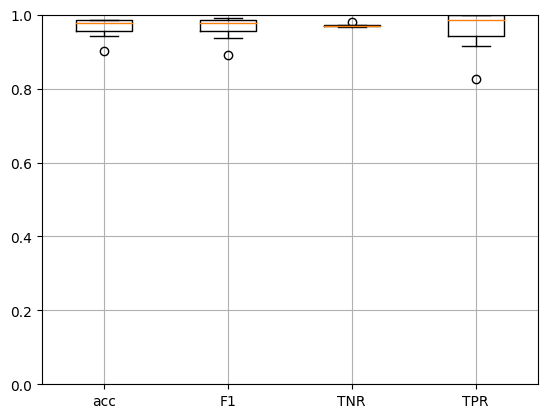

In [71]:
%matplotlib inline
plt.boxplot([acc, f1, tnr, tpr])
plt.grid("on")
plt.xticks([1, 2, 3, 4], ["acc", "F1", "TNR", "TPR"])
plt.ylim(ymin=0, ymax=1)
plt.show()

In [72]:
# Saving

df = pd.DataFrame()
df["Accuracy"] = acc
df["F1"] = f1
df["TNR"] = tnr
df["TPR"] = tpr


df.to_csv("./results_svm_chb01.csv", index=False)